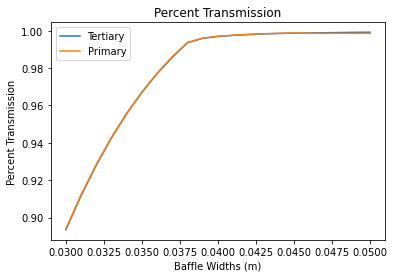

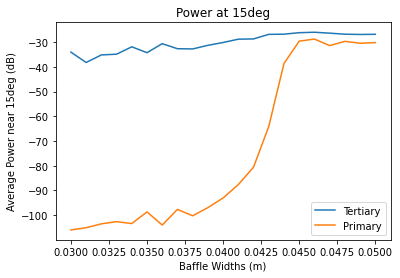

In [14]:
# Plot Baffle Radius vs % transmission and power at 13deg (Edge of Primary)
# Skeleton of this code was taken from Lens2Tertiary_v1.ipynb

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const
import poppy
from poppy.wfe import WavefrontError

fwhm_ = np.sqrt(np.log(2)/297.4178) * u.m 
lenslet_aperture = poppy.GaussianAperture(fwhm=fwhm_)
ff = 480*u.GHz # 420-540GHz
ll = const.c/ff
d_lenslet_lens = 24*u.cm

# Nominal radius=0.0381m
widths=u.Quantity(np.arange(0.03,0.05,0.001),u.m) #* u.m

# effective focal lengths of tertiary, secondary, primary
f_1 = 155 * u.cm
f_2 = 11940 * u.cm
f_3 = 19.2 * u.cm
tertiary_obj = poppy.QuadraticLens(f_lens=f_3)
secondary_obj = poppy.QuadraticLens(f_lens=f_2)
primary_obj = poppy.QuadraticLens(f_lens=f_1)

#Radii
coldstop = poppy.CircularAperture(radius=3.81*u.cm)
tertiary_radius = poppy.CircularAperture(radius=8*u.cm)
secondary_radius = poppy.CircularAperture(radius=14.697*u.cm)
primary_radius = poppy.CircularAperture(radius=40*u.cm)


# separations 
d_lens_3 = 33.06 * u.cm
d_3_2 = 86.562 * u.cm
d_IF = 19.2 * u.cm
d_2_1 = 104.995 * u.cm

spill_power, trans_power, dB_radius = np.zeros((len(widths),1)), np.zeros((len(widths),1)), np.zeros((len(widths),1))
p_spill_power, p_trans_power, p_dB_radius = np.zeros((len(widths),1)), np.zeros((len(widths),1)), np.zeros((len(widths),1))

w_idx=0
for width in widths:
    #width=width*u.m
    wf = poppy.FresnelWavefront(beam_radius=20*u.cm, wavelength=ll)
    
    #wf *= phase_gradient(4.5*u.mm,d_lenslet_lens,ff)

    wf *= lenslet_aperture
    
    ring = poppy.CircularAperture(radius=width)
    wf *= coldstop
    y, x = wf.coordinates()
    initial_power=np.sum(wf.intensity)

    wf.propagate_fresnel(0.35*u.cm)

    # 3 groups of 3 0.35 cm spaced baffles, with each group 1.1 cm apart
    for dummyvar in np.arange(1,4):
        for dummyvar2 in np.arange(1,3):
            wf *= ring    
            wf.propagate_fresnel(0.889*u.cm)
        wf *= ring
        wf.propagate_fresnel(2.794*u.cm)

    wf.propagate_fresnel(18.4643*u.cm) # propogate out to center of tertiary

    temp = wf.intensity
    y, x = wf.coordinates()
    count = 0
    for m in np.arange(0,x.shape[0],dtype=int):
        for n in np.arange(0,x.shape[1],dtype=int):
            if (0.08)**2 < x[m,n]**2 + y[m,n]**2 :
                spill_power[w_idx] += temp[m,n]  
            elif (0.043444710048611554)**2 < x[m,n]**2 + y[m,n]**2 < (0.04455867644331863)**2 :
                dB_radius[w_idx] += temp[m,n]
                count += 1
                trans_power[w_idx] += temp[m,n]
            else:
                trans_power[w_idx] += temp[m,n]
    dB_radius[w_idx]=10*np.log10(dB_radius[w_idx]/count)-10*np.log10(np.max(temp))
    
    wf *= tertiary_obj
    wf.propagate_fresnel(d_3_2) # could insert IF baffle instead too
    
    wf *= secondary_obj
    wf.propagate_fresnel(d_2_1)
    
    temp = wf.intensity
    y, x = wf.coordinates()
    count = 0
    for m in np.arange(0,x.shape[0],dtype=int):
        for n in np.arange(0,x.shape[1],dtype=int):
            if (0.4)**2 < x[m,n]**2 + y[m,n]**2 :
                p_spill_power[w_idx] += temp[m,n]  
            elif (0.39)**2 < x[m,n]**2 + y[m,n]**2 < (0.4)**2 :
                p_dB_radius[w_idx] += temp[m,n]
                count += 1
                p_trans_power[w_idx] += temp[m,n]
            else:
                p_trans_power[w_idx] += temp[m,n]
    p_dB_radius[w_idx]=10*np.log10(p_dB_radius[w_idx]/count)-10*np.log10(np.max(temp))
    
    #wf *= primary_obj
    
    w_idx += 1     
            
#plt.plot(x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]))

plt.plot(widths, trans_power/initial_power, label="Tertiary")
plt.plot(widths, p_trans_power/initial_power, label="Primary")
plt.title("Percent Transmission")
plt.xlabel("Baffle Widths (m)")
plt.ylabel("Percent Transmission")
plt.legend()
plt.show()

plt.plot(widths,dB_radius,label="Tertiary")
plt.plot(widths,p_dB_radius,label="Primary")
plt.title("Power at 15deg")
plt.xlabel("Baffle Widths (m)")
plt.ylabel("Average Power near 15deg (dB)")
plt.legend()
plt.show()


In [4]:
# Trevor's phase gradient code
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const
import poppy
from poppy.wfe import WavefrontError

class phase_gradient(WavefrontError):
    def __init__(self,x_center_offset,d_z,freq, **kwargs):
        super(WavefrontError, self).__init__(name='Phase Gradient', **kwargs)
        
        self.x_center_offset=x_center_offset
        self.d_z=d_z
        self.freq=freq
    
    def get_opd(self, wave):
        """
        Parameters
        ----------
        wave : poppy.Wavefront (or float)
            Incoming Wavefront before this optic to set wavelength and
            scale, or a float giving the wavelength in meters
            for a temporary Wavefront used to compute the OPD.
        """

        y, x = self.get_coordinates(wave)*u.m  # in meters
        k=2*np.pi*self.freq/const.c

        opd = -((x.to(u.cm)+self.x_center_offset.to(u.cm))**2/(2*self.d_z)).to(u.m).value
        
        return opd
    

In [12]:
import numpy as np
import astropy.units as u
from astropy import constants as const
d_3_2 = 86.562 * u.cm
d_IF = 19.2 * u.cm
d_2_1 = 104.995 * u.cm
np.arctan((39*u.cm)/(d_2_1+d_3_2-d_IF))*180/np.pi

<Quantity 12.74987118 rad>

In [13]:
19.2*np.tan(12.749871*np.pi/180) #Calculating position of 'edge' region on tertiary

4.3444710048611554

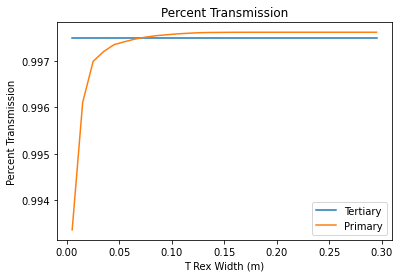

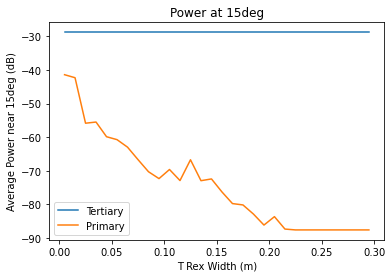

In [19]:
# Plot % transmission and power at 15deg vs t-rex width

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const
import poppy
from poppy.wfe import WavefrontError

fwhm_ = np.sqrt(np.log(2)/297.4178) * u.m 
lenslet_aperture = poppy.GaussianAperture(fwhm=fwhm_)
ff = 480*u.GHz # 420-540GHz
ll = const.c/ff
d_lenslet_lens = 24*u.cm

# Nominal radius=0.0381m
widths=u.Quantity(np.arange(0.005,0.3,0.01),u.m) #* u.m

# effective focal lengths of tertiary, secondary, primary
f_1 = 155 * u.cm
f_2 = 11940 * u.cm
f_3 = 19.2 * u.cm
tertiary_obj = poppy.QuadraticLens(f_lens=f_3)
secondary_obj = poppy.QuadraticLens(f_lens=f_2)
primary_obj = poppy.QuadraticLens(f_lens=f_1)

#Radii
coldstop = poppy.CircularAperture(radius=3.81*u.cm)
ring = poppy.CircularAperture(radius=4.1*u.cm)
tertiary_radius = poppy.CircularAperture(radius=8*u.cm)
secondary_radius = poppy.CircularAperture(radius=14.697*u.cm)
primary_radius = poppy.CircularAperture(radius=40*u.cm)


# separations 
d_lens_3 = 33.06 * u.cm
d_3_2 = 86.562 * u.cm
d_IF = 19.2 * u.cm
d_2_1 = 104.995 * u.cm

spill_power, trans_power, dB_radius = np.zeros((len(widths),1)), np.zeros((len(widths),1)), np.zeros((len(widths),1))
p_spill_power, p_trans_power, p_dB_radius = np.zeros((len(widths),1)), np.zeros((len(widths),1)), np.zeros((len(widths),1))

w_idx=0
for width in widths:
    #width=width*u.m
    wf = poppy.FresnelWavefront(beam_radius=20*u.cm, wavelength=ll)
    
    #wf *= phase_gradient(4.5*u.mm,d_lenslet_lens,ff)

    wf *= lenslet_aperture
    
    wf *= coldstop
    y, x = wf.coordinates()
    initial_power=np.sum(wf.intensity)

    wf.propagate_fresnel(0.35*u.cm)

    # 3 groups of 3 0.35 cm spaced baffles, with each group 1.1 cm apart
    for dummyvar in np.arange(1,4):
        for dummyvar2 in np.arange(1,3):
            wf *= ring    
            wf.propagate_fresnel(0.889*u.cm)
        wf *= ring
        wf.propagate_fresnel(2.794*u.cm)

    wf.propagate_fresnel(18.4643*u.cm) # propogate out to center of tertiary

    temp = wf.intensity
    y, x = wf.coordinates()
    count = 0
    for m in np.arange(0,x.shape[0],dtype=int):
        for n in np.arange(0,x.shape[1],dtype=int):
            if (0.08)**2 < x[m,n]**2 + y[m,n]**2 :
                spill_power[w_idx] += temp[m,n]  
            elif (0.043444710048611554)**2 < x[m,n]**2 + y[m,n]**2 < (0.04455867644331863)**2 :
                dB_radius[w_idx] += temp[m,n]
                count += 1
                trans_power[w_idx] += temp[m,n]
            else:
                trans_power[w_idx] += temp[m,n]
    dB_radius[w_idx]=10*np.log10(dB_radius[w_idx]/count)-10*np.log10(np.max(temp))
    
    wf *= tertiary_obj

    wf.propagate_fresnel(d_IF) 
    
    trex = poppy.CircularAperture(radius=width)
    wf *= trex
    
    wf.propagate_fresnel(d_3_2-d_IF)
    
    wf *= secondary_obj
    wf.propagate_fresnel(d_2_1)
    
    temp = wf.intensity
    y, x = wf.coordinates()
    count = 0
    for m in np.arange(0,x.shape[0],dtype=int):
        for n in np.arange(0,x.shape[1],dtype=int):
            if (0.4)**2 < x[m,n]**2 + y[m,n]**2 :
                p_spill_power[w_idx] += temp[m,n]  
            elif (0.39)**2 < x[m,n]**2 + y[m,n]**2 < (0.4)**2 :
                p_dB_radius[w_idx] += temp[m,n]
                count += 1
                p_trans_power[w_idx] += temp[m,n]
            else:
                p_trans_power[w_idx] += temp[m,n]
    p_dB_radius[w_idx]=10*np.log10(p_dB_radius[w_idx]/count)-10*np.log10(np.max(temp))
    
    #wf *= primary_obj
    
    w_idx += 1     
            
#plt.plot(x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]))

plt.plot(widths, trans_power/initial_power, label="Tertiary")
plt.plot(widths, p_trans_power/initial_power, label="Primary")
plt.title("Percent Transmission")
plt.xlabel("T Rex Width (m)")
plt.ylabel("Percent Transmission")
plt.legend()
plt.show()

plt.plot(widths,dB_radius,label="Tertiary")
plt.plot(widths,p_dB_radius,label="Primary")
plt.title("Power at 13deg")
plt.xlabel("T Rex Width (m)")
plt.ylabel("Average Power near 13deg (dB)")
plt.legend()
plt.show()


In [20]:
np.sqrt(np.log(2)/297.4178) * u.m 

<Quantity 0.04827577 m>